### Qiime2-Swarm pipeline for 16S/18S data processing

This pipeline takes standard output from John Mccrow's SSU-Swarm pipeline and convert data into qiime compatible formats 

##### Version: N/A (2/21/2019)

##### Niu Du (dniu [at] jcvi.org)
##### J. Craig Venter Institute (JCVI)
##### La Jolla, CA USA

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
from scipy.spatial.distance import pdist,squareform
from skbio.stats.ordination import pcoa
from scipy.interpolate import griddata
from skbio import DistanceMatrix
from skbio import diversity
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO,Phylo
from IPython.display import IFrame
from scipy.stats import linregress


import plotly.offline as py
import plotly.graph_objs as go
import ecopy as ep
from plotly import tools
import warnings
warnings.filterwarnings("ignore")

In [3]:
sns.set(context='paper', style="whitegrid", palette='dark', font='sans-serif:Arial', font_scale=1, color_codes=False, rc=None)
sns.set_style("ticks", {"xtick.major.size": 3, "ytick.major.size": 3})
sns.set_context("paper",font_scale=1, rc={"font.size":24,"axes.titlesize":12,"axes.labelsize":12})   

In [4]:
# Set work directory here
os.environ['base'] = '/local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template'
os.environ['Work_dir'] = os.environ['base']+'/results'
os.environ['classifier_dir'] = '/local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/db/Ocean_database/classifier/silva-132-99-515-806-nb-classifier.qza'
!mkdir -p $Work_dir

In [5]:
# specify input tables

# Count table
os.environ['count_table'] = os.environ['base']+'/CalCOFI_2012-2016/CalCOFI_concat_16S.swarm.tax'
# Representative sequences
os.environ['rep_seq'] = os.environ['base']+'/CalCOFI_2012-2016/CalCOFI_concat_16S.swarm.fa'
# Metadata
os.environ['meta_file'] = os.environ['base']+'/CalCOFI_2012-2016/meta_data.csv'


In [6]:
# Diversity methods to be used besides core-metrics (faith-PD and unifracs)
a_div_methods = ['ace', 'berger_parker_d', 'brillouin_d', 'chao1', 'dominance', 'doubles', 'enspie',  'fisher_alpha', 'gini_index', 'goods_coverage', 'heip_e', 'lladser_pe', 'margalef', 'mcintosh_d', 'mcintosh_e', 'menhinick', 'observed_otus', 'pielou_e', 'robbins', 'shannon', 'simpson', 'simpson_e', 'singles', 'strong']
b_div_methods = ['braycurtis', 'canberra', 'chebyshev', 'cityblock', 'correlation', 'cosine', 'dice', 'euclidean', 'hamming', 'jaccard', 'kulsinski', 'matching', 'rogerstanimoto', 'russellrao', 'seuclidean', 'sokalmichener', 'sokalsneath', 'sqeuclidean', 'yule']

In [7]:
# String error in df_taxa_count table columns, fixed here - the column names must match names in metadata files
## This may not needed for other samples
df_taxa_count = pd.read_table(os.environ['count_table']).set_index('id')
Fix_sta =['20'+x[:-4] for x in df_taxa_count.columns[2:]]
New_col = list(df_taxa_count.columns[:2])+ Fix_sta
New_col_T = [x[:-1]+'T' if x[-2:] == '_t' else x for x in New_col]
df_taxa_count.columns = New_col_T
df_taxa_count = df_taxa_count.dropna()

In [8]:
# metadata should be cleaned up - make sure the sample id matches in both count and meta tables

## The index name must match the id column name in the meta table

# If comma separated file, change '\t' to ','
meta_data = pd.read_csv(os.environ['meta_file'],sep = '\t').set_index('sampleid')

In [144]:
# Qiime only recognize tap separated files, run this step if error occured in the following step
# meta_data.to_csv(os.environ['meta_file'],sep = '\t')

In [145]:
# Filter out OTUs with very low counts for all of the following analysis and remove the coresponding OTUs
df_otu_count = df_taxa_count[list(set(df_taxa_count.columns).intersection(meta_data.index))]
index_match = list(set(meta_data.index).intersection(df_otu_count.columns))
df_otu_count_filter = df_otu_count[index_match]
df_otu_count_filter = df_otu_count.loc[df_otu_count.sum(axis = 1)>100] # minimal counting frequency
otu_seq_dict = SeqIO.to_dict(rec.upper() for rec in SeqIO.parse(os.environ['rep_seq'],'fasta'))
otu_seq_dict_filter = [otu_seq_dict[i] for i in df_otu_count_filter.index]
with open(os.environ['Work_dir']+'/rep-sequence-filtered.fa', "w") as handle:
    SeqIO.write(otu_seq_dict_filter, handle, "fasta") 

In [9]:
# Import the filtered OTU sequences here 
!qiime tools import \
  --input-path $Work_dir/rep-sequence-filtered.fa \
  --output-path $Work_dir/rep-seqs.qza \
  --type 'FeatureData[Sequence]'

Imported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/rep-sequence-filtered.fa as DNASequencesDirectoryFormat to /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/rep-seqs.qza


In [147]:
# Now Doing alignment and build a phylogeny tree based on clusters

!qiime alignment mafft \
  --i-sequences $Work_dir/rep-seqs.qza \
  --o-alignment $Work_dir/aligned-rep-seqs.qza

!qiime alignment mask \
  --i-alignment $Work_dir/aligned-rep-seqs.qza \
  --o-masked-alignment $Work_dir/masked-aligned-rep-seqs.qza

!qiime phylogeny fasttree \
  --i-alignment $Work_dir/masked-aligned-rep-seqs.qza \
  --o-tree $Work_dir/unrooted-tree.qza

!qiime phylogeny midpoint-root \
  --i-tree $Work_dir/unrooted-tree.qza \
  --o-rooted-tree $Work_dir/rooted-tree.qza


Saved FeatureData[AlignedSequence] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/aligned-rep-seqs.qza
Saved FeatureData[AlignedSequence] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/masked-aligned-rep-seqs.qza
Saved Phylogeny[Unrooted] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/unrooted-tree.qza
Saved Phylogeny[Rooted] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/rooted-tree.qza


In [166]:
# Export tree; for faith and unifrac distance calculation 
!qiime tools export \
  --input-path $Work_dir/rooted-tree.qza \
  --output-path  $Work_dir/exported-tree/rooted

!qiime tools export \
  --input-path $Work_dir/unrooted-tree.qza \
  --output-path  $Work_dir/exported-tree/unrooted

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/rooted-tree.qza as NewickDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/exported-tree/rooted
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/unrooted-tree.qza as NewickDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/exported-tree/unrooted


In [149]:
########################### Unifrac analysis of raw OTUs ###############################


In [150]:
# Convert filtered OTU table to biom format so it can be used in Qiime2

df_otu_count_filter.to_csv(os.environ['Work_dir']+'/df_otu_count_filter.txt',sep = '\t')
!biom convert -i $Work_dir/df_otu_count_filter.txt -o $Work_dir/Otu_count_filter.biom --to-hdf5

!qiime tools import \
  --input-path $Work_dir/Otu_count_filter.biom \
  --output-path $Work_dir/otu_count_filter.qza \
  --type 'FeatureTable[Frequency]'

Imported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/Otu_count_filter.biom as BIOMV210DirFmt to /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/otu_count_filter.qza


In [151]:
# Generrate alpha rarefaction curves to determine the minimal sequence depth for a-diversity 
!time qiime diversity alpha-rarefaction \
    --i-table $Work_dir/otu_count_filter.qza \
    --p-max-depth 50000 \
    --i-phylogeny $Work_dir/rooted-tree.qza \
    --m-metadata-file $meta_file \
    --output-dir $Work_dir/alpha-rarefraction


Saved Visualization to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha-rarefraction/visualization.qzv

real	2m21.527s
user	2m16.835s
sys	0m2.047s


In [152]:
# Generate diversity metrics, using the selected sequencing depth  
!time qiime diversity core-metrics-phylogenetic \
  --i-phylogeny $Work_dir/rooted-tree.qza \
  --i-table $Work_dir/otu_count_filter.qza \
  --p-sampling-depth 12000 \
  --m-metadata-file $meta_file \
  --output-dir $Work_dir/core-metrics-results

Saved FeatureTable[Frequency] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/rarefied_table.qza
Saved SampleData[AlphaDiversity] % Properties(['phylogenetic']) to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/observed_otus_vector.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/evenness_vector.qza
Saved DistanceMatrix % Properties(['phylogenetic']) to: /local/ifs2_projdata/0568/project

In [153]:
# Rarefying OTU table - Filter out samples that do not meet the minimal seq depth requirement
!rm -r $Work_dir/normalized_otu/
!qiime feature-table rarefy \
    --i-table $Work_dir/otu_count_filter.qza \
    --p-sampling-depth 12000 \
    --output-dir $Work_dir/normalized_otu/

rm: cannot remove '/local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/normalized_otu/': No such file or directory
Saved FeatureTable[Frequency] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/normalized_otu/rarefied_table.qza


In [154]:
!mkdir -p $Work_dir/alpha_div
for method in a_div_methods:
    os.environ['method'] = method
    !qiime diversity alpha \
      --i-table $Work_dir/normalized_otu/rarefied_table.qza \
      --p-metric $method \
      --o-alpha-diversity $Work_dir/alpha_div/$method.qza

Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/ace.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/berger_parker_d.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/brillouin_d.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/chao1.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/dominance.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/doubles.qza
Saved SampleData[AlphaDiversity] to: /local/ifs2_p

In [167]:
for method in a_div_methods:
    os.environ['method'] = method
    !qiime tools export \
      --input-path $Work_dir/alpha_div/$method.qza \
      --output-path $Work_dir/alpha_div/$method

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/ace.qza as AlphaDiversityDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/ace
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/berger_parker_d.qza as AlphaDiversityDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/berger_parker_d
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/brillouin_d.qza as AlphaDiversityDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alpha_div/brillouin_d
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/alph

In [156]:
!mkdir -p $Work_dir/beta_div
for method in b_div_methods:
    os.environ['method'] = method
    !qiime diversity beta \
        --i-table $Work_dir/normalized_otu/rarefied_table.qza \
        --p-metric $method \
        --o-distance-matrix $Work_dir/beta_div/$method.qza

Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/braycurtis.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/canberra.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/chebyshev.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/cityblock.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/correlation.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/cosine.qza
Saved DistanceMatrix to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/be

In [157]:
for method in b_div_methods:
    os.environ['method'] = method
    !qiime tools export \
      --input-path $Work_dir/beta_div/$method.qza \
      --output-path  $Work_dir/beta_div/$method

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/braycurtis.qza as DistanceMatrixDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/braycurtis
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/canberra.qza as DistanceMatrixDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/canberra
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/chebyshev.qza as DistanceMatrixDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/chebyshev
Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/beta_div/cityb

In [158]:
# Getting Faith-alpha diversity data

!qiime tools export \
  --input-path $Work_dir/core-metrics-results/faith_pd_vector.qza \
  --output-path $Work_dir/core-metrics-results/Faith_PD/

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/faith_pd_vector.qza as AlphaDiversityDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/Faith_PD/


In [159]:
# Getting weighted unifrac diversity data

!qiime tools export \
  --input-path $Work_dir/core-metrics-results/weighted_unifrac_distance_matrix.qza \
  --output-path $Work_dir/core-metrics-results/weighted_unifrac/

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/weighted_unifrac_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/weighted_unifrac/


In [160]:
# Getting unweighted unifrac diversity data

!qiime tools export \
  --input-path $Work_dir/core-metrics-results/unweighted_unifrac_distance_matrix.qza \
  --output-path $Work_dir/core-metrics-results/unweighted_unifrac/

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/unweighted_unifrac_distance_matrix.qza as DistanceMatrixDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/core-metrics-results/unweighted_unifrac/


In [161]:
df_Faith_PD = pd.read_csv(os.environ['Work_dir']+'/core-metrics-results/Faith_PD/alpha-diversity.tsv',sep = '\t',index_col='Unnamed: 0')
df_unifrac_weighted = pd.read_csv(os.environ['Work_dir']+'/core-metrics-results/weighted_unifrac/distance-matrix.tsv',sep = '\t',index_col='Unnamed: 0')
df_unifrac_unweighted = pd.read_csv(os.environ['Work_dir']+'/core-metrics-results/unweighted_unifrac/distance-matrix.tsv',sep = '\t',index_col='Unnamed: 0')

In [162]:
# Calculating contour
df_Faith_PD = df_Faith_PD.merge(meta_data,left_index=True,right_index=True)

In [163]:
# Make dataframe that contains all alphadiversity data 

In [172]:
df_alpha_all = df_Faith_PD.copy()

In [173]:
df_alpha_all = df_Faith_PD.copy()
for method in a_div_methods:
    df_alpha_all = df_alpha_all.merge(pd.read_csv(os.environ['Work_dir']+'/alpha_div/'+method+'/alpha-diversity.tsv',sep = '\t',index_col='Unnamed: 0'),left_index=True,right_index=True)

In [174]:
# Make dictionary that contains all beta diversity matrices

In [175]:
dict_beta_all = {'unifrac_weighted':df_unifrac_weighted,'unifrac_unweighted':df_unifrac_unweighted}
for method in b_div_methods:
    dict_beta_all[method] = pd.read_csv(os.environ['Work_dir']+'/beta_div/'+method+'/distance-matrix.tsv',sep = '\t',index_col='Unnamed: 0')

In [177]:
# Data export for Metagenomics Vis pipeline
df_alpha_all.to_pickle(os.environ['Work_dir']+'/df_alpha_meta.pkl')

import pickle
with open(os.environ['Work_dir']+"/dict_beta.pkl", "wb") as f:
    pickle.dump(dict_beta_all, f)

In [ ]:
###### Up to this point all analysis was done using OTU information directly #######

###### You can now run the diversity analysis and make plots in the ohter notebook ######

###### Starting from here Taxa information will be included ######

################### Redo annotations using trained classifier ################

In [178]:
# When 151 - 926 primers wer used, need to trim it down before classification, because the sequences are too long, using 515-806 primer pairs
!time qiime feature-classifier extract-reads \
  --i-sequences $Work_dir/rep-seqs.qza \
  --p-f-primer GTGYCAGCMGCCGCGGTAA \
  --p-r-primer GGACTACHVHHHTWTCTAAT \
  --o-reads $Work_dir/trimmed-rep-seqs.qza

Saved FeatureData[Sequence] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/trimmed-rep-seqs.qza

real	17m45.352s
user	17m44.569s
sys	0m0.418s


In [179]:
# This step runs on the grid; make sure it was finished before running the next step
!qsub -P 0746 -N qiime -cwd -e gridout/err -o grid/out \
./qiime-classify.py -p 8 \
-r $classifier_dir \
-i $Work_dir/trimmed-rep-seqs.qza \
-o $Work_dir/taxonomy.qza

Your job 9438917 ("qiime") has been submitted


In [13]:
!qiime tools export \
    --input-path $Work_dir/taxonomy.qza \
    --output-path $Work_dir/taxa/ \

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/taxonomy.qza as TSVTaxonomyDirectoryFormat to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/taxa/


In [55]:
def extract_string(x):
    if str(x) == 'None':
        return str(x)
    else: 
        return str(x).split('__')[1]
df_taxa = pd.read_table(os.environ['Work_dir']+'/taxa/taxonomy.tsv',sep = '\t').set_index('Feature ID')
df_taxa_info = pd.DataFrame([taxa.split(';') for taxa in df_taxa.Taxon]).fillna('None').applymap(extract_string)
df_taxa_info.index = df_taxa.index
df_taxa_info.columns = [str('D'+str(i+1)) for i in range(len(df_taxa_info.columns))]

################### Dissimilarity between samples using ANOVA test ################

In [56]:
# log transfer normalized otu counts 

In [57]:
Out_count_filter = pd.read_table(os.environ['Work_dir']+'/df_otu_count_filter.txt').set_index('id')

In [62]:
# Adding pseudo counts to avoid error in log transformation
!time qiime composition add-pseudocount \
    --i-table $Work_dir/normalized_otu/rarefied_table.qza \
    --p-pseudocount 1 \
    --o-composition-table $Work_dir/normalized_otu/otu_pesudo_composition.qza

Saved FeatureTable[Composition] to: /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/normalized_otu/otu_pesudo_composition.qza

real	0m7.139s
user	0m5.736s
sys	0m0.421s


In [63]:
# Export the log transferred count table
!qiime tools export \
  --input-path $Work_dir/normalized_otu/otu_pesudo_composition.qza\
  --output-path  $Work_dir/normalized_otu/

!biom convert -i $Work_dir/normalized_otu/feature-table.biom -o $Work_dir/normalized_otu/feature-table.txt --to-tsv

Exported /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/normalized_otu/otu_pesudo_composition.qza as BIOMV210DirFmt to directory /local/ifs2_projdata/0568/projects/PLANKTON/illumina_aallen/ndu/Templates/Qiime2_template/results/normalized_otu/


In [64]:
df_otu_counts = pd.read_table(os.environ['Work_dir']+'/normalized_otu/feature-table.txt',sep = '\t',header = 1).set_index('#OTU ID')
df_otu_counts = df_otu_counts[df_otu_counts.columns.sort_values()]
df_otu_counts_log = df_otu_counts.apply(np.log)

In [65]:
from Du_functions import Hawk_smash

# ANOVA test returns 
# 1. dict of entiched OTU for each group based on adjusted p value of selection and 
# 2. dict of ANOVA result in dataframe for each group
from Du_functions import ANOVA_test
from Du_functions import Count_OTU_by_reference

In [66]:
# Adjusted p cutting off value
p_adj_threshold = 0.001

In [67]:
# Generate a dictionary that include all group name - samples relations

''' * Need to make your own definition here
    Group_factor -  find the groups that you wish to run the ANOVA test in meta data file, and put the column name here
    Group_list - types exist within the group of interest, put them in the order that you wish to show in the table 
'''
dict_enriched_region,df_region_ANOVA = ANOVA_test(meta_data,df_otu_counts_log,Group_factor = 'Code_CCE',Group_list = ['Off','CC','SCB','Up'],P_cut=p_adj_threshold)
dict_enriched_depth_1,df_depth_1_ANOVA = ANOVA_test(meta_data,df_otu_counts_log,Group_factor = 'Depth_bin_1',Group_list = ['0-25', '25-50', '50-75', '>75'],P_cut=p_adj_threshold)
dict_enriched_depth_2,df_depth_2_ANOVA = ANOVA_test(meta_data,df_otu_counts_log,Group_factor = 'Depth_bin_2',Group_list = ['<50', '>50'],P_cut=p_adj_threshold)
dict_enriched_depth_3,df_depth_3_ANOVA = ANOVA_test(meta_data,df_otu_counts_log,Group_factor = 'Depth_bin_3',Group_list = ['<20', '>20'],P_cut=p_adj_threshold)
dict_enriched_OTU_all = {**dict_enriched_region,**dict_enriched_depth_1,**dict_enriched_depth_2,**dict_enriched_depth_3}

In [68]:
import pickle
with open(os.environ['base']+"/dict_enriched_OTU_all.pkl", "wb") as f:
    pickle.dump(dict_enriched_OTU_all, f)

In [69]:
dict_enriched_OTU_all = pickle.load(open( os.environ['base']+"/dict_enriched_OTU_all.pkl", "rb" ) )

In [70]:
# The reference list is a customized taxa annotation for grouping taxa - see example
df_Annotation_reference = pd.read_csv(os.environ['base']+'/CalCOFI_2012-2016/16S_Annotation_reference_list.csv').set_index('Name')

In [71]:
df_reference_counts = df_Annotation_reference.copy()
for group in dict_enriched_OTU_all.keys():
    df_candidate = df_taxa_info.loc[dict_enriched_OTU_all[group]].dropna()
    _,df_temp = Count_OTU_by_reference(df_candidate,df_Annotation_reference,group)
    df_reference_counts = df_reference_counts.merge(df_temp,left_index = True, right_index=True)

In [72]:
_,df_all_counts = Count_OTU_by_reference(df_taxa_info.loc[df_otu_counts.index],df_Annotation_reference,'All')

In [73]:
df_reference_counts[['D1', 'D2', 'D3', 'D4', 'D5', 'D6','Off','CC','SCB','Up','0-25', '25-50', '50-75', '>75','<50', '>50','<20', '>20']].merge(df_all_counts,left_index = True, right_index = True).to_csv('16S_Taxa_group_p_0.001.csv')

In [74]:
Factors = ['Temp', 'Sal', 'Density', 'O2', 'PO4', 'SiO3', 'NO3', 'NH3', 'Chla', 'PhaePig', 'PO4_log','SiO3_log', 'NO3_log',
       'NH3_log', 'Chla_log','ChlaAnom','PhaePig_log', 'NCDepth_log','PO4Anom', 'SiO3Anom', 'NO2Anom', 'NO3Anom','NCDepth', 'TempAnom']

In [75]:
# Perform linear regression on the selected OTUs

dict_linear = {}
for group in tqdm(dict_enriched_OTU_all.keys()):
    Model_coef = np.zeros((len(dict_enriched_OTU_all[group]),len(Factors)))
    for OTU_ID,OTU in enumerate(df_otu_counts.loc[dict_enriched_OTU_all[group]].index):
        for Factor_ID,Factor in enumerate(Factors):
            C,_,_,P,_ = linregress(df_otu_counts_log.loc[OTU],meta_data.loc[df_otu_counts.columns][Factor])
            Model_coef[OTU_ID,Factor_ID] = C if P<0.05 else 0 # The p value here is for linear regression, not ANOVA
    dict_linear[group] = pd.DataFrame(Model_coef,index=df_otu_counts.loc[dict_enriched_OTU_all[group]].index,columns=Factors)
    

100%|██████████| 12/12 [03:34<00:00, 17.83s/it]


In [23]:
writer = pd.ExcelWriter(os.environ['base']+'/results/16S_summary_linear_all_P_0.001.xlsx', engine='xlsxwriter')
for group in tqdm(['Off','CC','SCB','Up','0-25', '25-50', '50-75', '>75','<50', '>50','<20', '>20']):
    df = df_taxa_info.merge(dict_linear[group],left_index =True, right_index = True) 
    df = df.loc[dict_enriched_OTU_all[group]].merge(df_otu_counts,how = 'inner',left_index =True, right_index = True)
    df = df[df.D1 != 'Eukaryota']
    df.to_excel(writer, sheet_name=group)
writer.save()

100%|██████████| 12/12 [00:26<00:00,  2.81s/it]


############################## CCA plot ##############################

In [77]:
# Using the annotation list from Andy to mark OTUs on the CCA plot
'''This step has to be done manually; download the xlsx file generated from previous step, 
add in the last column the initials or other custom names for each OTU based on the taxa info. 
After finished editing the xlsx file, upload it to the folder and run (change the file name below)
'''
import xlrd
dict_otu_initials = {}
workbook = xlrd.open_workbook("./16S_summary_linear_AA.xlsx")
for tap in workbook.sheets():
    dict_otu_initials.update(dict(zip(tap.col_values(0)[1:],tap.col_values(-1)[1:]))) 
    # dict_otu_initials.update(dict(zip(tap.col_values(0)[1:],tap.col_values(37)[1:]))) 

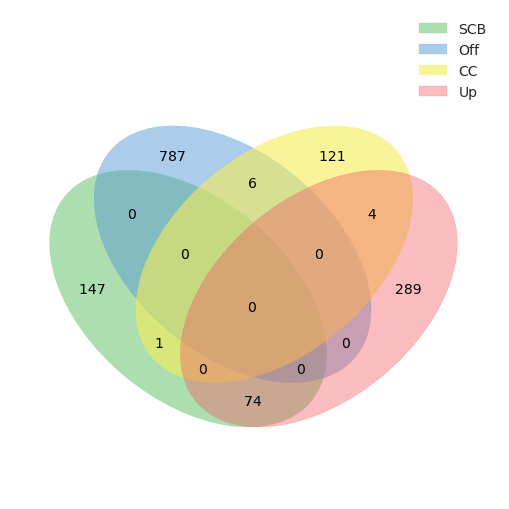

In [83]:
# Optional check the Venn diagram for the unique OTUs
import venn
%matplotlib inline
names = ['SCB','Off','CC','Up']
# names = ['0-25', '25-50', '50-100', '>100']
labels = venn.get_labels([set(dict_enriched_region[x]) for x in names])
#labels = venn.get_labels([dict_enriched_OTU_depth[x] for x in names])

fig, ax = venn.venn4(labels = labels, names=names)
fig.show()

In [84]:
df_otu_counts_Code = df_otu_counts.copy().T
df_otu_counts_Code = df_otu_counts_Code.merge(meta_data[['Code_CCE']],left_index = True, right_index=True)
df_otu_counts_Code = df_otu_counts_Code.groupby('Code_CCE').sum().T
df_otu_counts_Code['Total'] = df_otu_counts_Code.sum(axis = 1)
df_otu_counts_Code['w_abundance'] = pd.cut(np.log(df_otu_counts_Code['Total']),bins = 100, labels=np.arange(100))

# Getting uniquely enriched OTUs
dict_enriched_region_unique = {}
for name in dict_enriched_region.keys():
    temp_name = names.copy()
    temp_name.remove(name)
    dict_enriched_region_unique[name] = list(set(dict_enriched_region[name]) - set([item for sublist in [dict_enriched_region[x] for x in temp_name] for item in sublist])
)
df_otu_summary = {}
for region in ['Off','CC','SCB','Up']:
    temp = df_region_ANOVA[region].loc[dict_enriched_region_unique[region]].sort_values('F_ratio',ascending = False)
    temp['w_F_ratio'] = pd.cut(np.log(temp.F_ratio),bins = 100, labels=np.arange(100))
    df_otu_summary[region] = temp.merge(df_otu_counts_Code,left_index = True, right_index=True)
    df_otu_summary[region]['Weight'] = np.array(df_otu_summary[region]['w_F_ratio'])*0.5+np.array(df_otu_summary[region]['w_abundance'])*0.5

In [85]:
writer = pd.ExcelWriter('16S_weight_sorted_OTU.xlsx', engine='xlsxwriter')
for group in tqdm(['Off','CC','SCB','Up']):
    df = df_otu_summary[group].sort_values('Weight',ascending = False).merge(df_taxa_info,how = 'inner',left_index =True, right_index = True)
    df.to_excel(writer, sheet_name=group)
writer.save()

100%|██████████| 4/4 [00:00<00:00,  7.36it/s]


In [88]:
# Color code the OTUs in the scatter plot
dict_region_color = {'Off':'blue','CC':'orange','SCB':'green','Up':'red'}
dict_otu_color = dict(zip(df_otu_counts.index,['lightgray']*len(df_otu_counts)))

for region in ['Off','CC','SCB','Up']:
    for otu in dict_enriched_region[region]:
        dict_otu_color[otu] = dict_region_color[region]

# Make a dictonary for number of OTUs to annotate ateach region
dict_number_selection = {'Off':20,'CC':0,'SCB':0,'Up':20}

list_selected_otu = [df_region_ANOVA[region].loc[dict_enriched_region[region]].sort_values('F_ratio', ascending= False).index[:dict_number_selection[region]] for region in ['Off','CC','SCB','Up']]
list_spp_name = [dict_otu_initials[x] for x in Hawk_smash(list_selected_otu)]
list_spp_color = Hawk_smash([[dict_region_color[x]]*dict_number_selection[x] for x in ['Off','CC','SCB','Up']])

In [89]:
# CCA analysis here; need to be customized 

# modified the list of factors used
df_CCA_factor = meta_data[['Temp', 'NCDepth','Chla','O2','NO3','Density']].dropna()
df_group_CCA = df_otu_counts.T.loc[df_CCA_factor.index].dropna()
df_CCA_factor = df_CCA_factor.loc[df_group_CCA.index]

# Overall CCA
from skbio.stats.ordination import cca
mb_all = cca(df_group_CCA,df_CCA_factor)

In [90]:

from itertools import repeat

Data_select = mb_all.features

# Case features
CCA_color = [dict_otu_color[x] for x in Data_select.index]

#Case samples
#CCA_color = meta_data.loc[mb_all.samples.index].Code_CCE.map(lambda x:{'Off':'blue','CC':'orange','SCB':'green','Up':'red'}[x])
trace = go.Scatter(
            x=Data_select['CCA1']/max(abs(Data_select['CCA1'])),
            y=Data_select['CCA2']/max(abs(Data_select['CCA2'])),
            text = Data_select.index,
            hoverinfo = 'text',
            mode = 'markers',
            marker=dict(
                size=4,
                opacity=0.5,
                color = CCA_color,
                showscale=False,
                )
)


trace2 = go.Scatter(
            x=mb_all.biplot_scores['CCA1']*3/max(abs(Data_select['CCA1'])),
            y=mb_all.biplot_scores['CCA2']*3/max(abs(Data_select['CCA2'])),
            text = list(mb_all.biplot_scores.index),
            textposition='bottom center',
            hoverinfo = 'text',
            mode = 'markers+text',
            marker=dict(
                size= 0.1,
                opacity=1,
                )
)

trace_annotation = go.Scatter(
            x=Data_select['CCA1'].loc[Hawk_smash(list_selected_otu)]/max(abs(Data_select['CCA1'])),
            y=Data_select['CCA2'].loc[Hawk_smash(list_selected_otu)]/max(abs(Data_select['CCA2'])),
            text = list_spp_name,
            hoverinfo = None,
            textposition='top center',
            mode = 'markers+text',
            marker=dict(
                symbol = "circle-open",
                size=10,
                opacity=0.9,
                color = 'black',
                showscale=False,
                ),
            textfont=dict(size = 12,color = list_spp_color)
)

In [100]:
Dict_of_annotation = {}
for i in mb_all.biplot_scores['CCA1'].index:
    Dict_of_annotation[i] = dict(   ax=0,
                                    ay=0,
                                    axref='x',
                                    ayref='y',
                                    x=mb_all.biplot_scores['CCA1'].loc[i]*3/max(abs(Data_select['CCA1'])),
                                    y=mb_all.biplot_scores['CCA2'].loc[i]*3/max(abs(Data_select['CCA2'])),
                                    xref='x',
                                    yref='y',
                                    showarrow=True,
                                    arrowhead=3,
                                    arrowsize=1,
                                    arrowwidth=1.5,
                                    arrowcolor='#636363',
                                    opacity = 0.5,
                                    font=dict(
                                            family='Courier New, monospace',
                                            size=16
                                        )
                                    )
for i,j in enumerate(['Off','CC','SCB','Up']):#,'mixed']):
    Dict_of_annotation[i] = dict(   ax=0,
                                    ay=0,
                                    axref='x',
                                    ayref='y',
                                    x=-1,
                                    y=0.8-0.1*i,
                                    xref='x',
                                    yref='y',
                                    showarrow=False,
                                    text = j,
                                    font=dict(
                                            family='Courier New, monospace',
                                            size=16,
                                            color=dict_region_color[j]
                                        ),
                                    opacity = 1
                                    )

In [101]:
layout = go.Layout(showlegend=False,
                   annotations=list(Dict_of_annotation.values()),
                    xaxis=dict(
                    title='CCA1',
                    titlefont=dict(
                        family='Courier New, monospace',
                        size=18,
                        color='#7f7f7f'
                        )
                    ),

                    yaxis=dict(
                    title='CCA2',
                    titlefont=dict(
                        family='Courier New, monospace',
                        size=18,
                        color='#7f7f7f'
                        )
                    ),
                   
                  )

### Active the following codes if you wish to draw circles around scattered points

# layout['shapes']=[ {   'type': 'circle',
#                             'xref': 'x',
#                             'yref': 'y',
#                             'x0': min(Data_select.loc[dict_enriched_region['Off']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y0': min(Data_select.loc[dict_enriched_region['Off']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'x1': max(Data_select.loc[dict_enriched_region['Off']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y1': max(Data_select.loc[dict_enriched_region['Off']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'opacity': 0.5,
#                             'fillcolor': None,
#                             'line': {
#                                 'color': 'blue',
#                             },
#                         },
#                         {
#                             'type': 'circle',
#                             'xref': 'x',
#                             'yref': 'y',
#                             'x0': min(Data_select.loc[dict_enriched_region['CC']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y0': min(Data_select.loc[dict_enriched_region['CC']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'x1': max(Data_select.loc[dict_enriched_region['CC']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y1': max(Data_select.loc[dict_enriched_region['CC']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'opacity': 0.5,
#                             'fillcolor': None,
#                             'line': {
#                                 'color': 'orange',
#                             },
#                         },
#                         {
#                             'type': 'circle',
#                             'xref': 'x',
#                             'yref': 'y',
#                             'x0': min(Data_select.loc[dict_enriched_region['SCB']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y0': min(Data_select.loc[dict_enriched_region['SCB']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'x1': max(Data_select.loc[dict_enriched_region['SCB']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y1': max(Data_select.loc[dict_enriched_region['SCB']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'opacity': 0.5,
#                             'fillcolor': None,
#                             'line': {
#                                 'color': 'green',
#                             },
#                         },
#                         {
#                             'type': 'circle',
#                             'xref': 'x',
#                             'yref': 'y',
#                             'x0': min(Data_select.loc[dict_enriched_region['Up']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y0': min(Data_select.loc[dict_enriched_region['Up']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'x1': max(Data_select.loc[dict_enriched_region['Up']]['CCA1'])/max(abs(Data_select['CCA1'])),
#                             'y1': max(Data_select.loc[dict_enriched_region['Up']]['CCA2'])/max(abs(Data_select['CCA2'])),
#                             'opacity': 0.5,
#                             'fillcolor': None,
#                             'line': {
#                                 'color': 'red',
#                             },
#                         },
# #                        {
# #                             'type': 'circle',
# #                             'xref': 'x',
# #                             'yref': 'y',
# #                             'x0': min(Data_select.loc[dict_OTU_unique['mixed']]['CCA1'])/max(abs(Data_select['CCA1'])),
# #                             'y0': min(Data_select.loc[dict_OTU_unique['mixed']]['CCA2'])/max(abs(Data_select['CCA2'])),
# #                             'x1': max(Data_select.loc[dict_OTU_unique['mixed']]['CCA1'])/max(abs(Data_select['CCA1'])),
# #                             'y1': max(Data_select.loc[dict_OTU_unique['mixed']]['CCA2'])/max(abs(Data_select['CCA2'])),
# #                             'opacity': 0.8,
# #                             'fillcolor': None,
# #                             'line': {
# #                                 'color': 'purple',
# #                             },
# #                         }
#                   ]
                


fig = dict(data=[trace,trace2,trace_annotation],layout = layout) #
fig['layout'].update(height=900, width=1000,showlegend=False)

py.plot(fig,filename='results/CCA_16S.html', auto_open=False)#,image='png',image_filename='18S_'+Method_choice+'.png',image_height=image_size[0],image_width=image_size[1])
IFrame(src='results/CCA_16S.html',height=950, width=1050)